In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import time
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs
from sklearn.decomposition import PCA
from utils import *
from preprocessing import load_data
from RandomFeats import define_rand_feats
from DirectionalMLP import mlp_main, generate

In [2]:
### CONFIG
task = 'chem' # chem, ic50, ec50, potency
K = 32 # Num pca components
percentile = 25 # Upper pth percentile for subsets
solver = False # Solver for LogisticRegression (True - liblin, slower but better)
N = 1024 # Num betas to fit (Typically 512 or 1280)
M = 25_000 # Num betas to generate for inference (Typically 25k-100k)

In [3]:
data = load_data(task, K)

(5997, 1024)
(749, 1024)
(937, 1024)
(751, 1024)
(938, 1024)


In [4]:
np.random.seed(74)
X, Y = data['train']
D = K * 5
model = define_rand_feats(X, D)

In [5]:
print(X.shape)
print(Y.shape)

(5997, 32)
(5997,)


In [6]:
dirs = np.random.randn(N, K)
dirs = dirs / np.linalg.norm(dirs, axis=1, keepdims=True)

In [7]:
betas = []
accs = []
i = 0
print(f"Starting {len(dirs)} models")
start_time = time.time()
for dir in dirs:
    if i % 25 == 0 and i:
        curr_time = time.time()
        elapsed_time = (curr_time - start_time)/60 # min
        print(f"Step {i} - Time Elapsed: {elapsed_time:.2f} min - est {elapsed_time/i*len(dirs) - elapsed_time:.2f} min remaining")
        print(f"\t\tCurrent Beta Accuracy: {np.mean(np.array(accs))}")

    X_sub, X_ids = project_and_filter(X, dir, percentile)
    Y_sub = Y[X_ids]
    beta, acc = log_coeffs(model(X_sub), Y_sub, solver)

    betas.append(beta)
    accs.append(acc)
    i += 1
    if i == len(dirs) - 1: print(f"Done")

betas = np.array(betas)
accs = np.array(accs)

Starting 16 models
Done


In [8]:
betas = tf.squeeze(betas)
dirs = tf.constant(dirs)
print("Modeling Training complete with Subset Accuracies: ", np.mean(accs))

Modeling Training complete with Subset Accuracies:  0.9945002498334443


Accuracy:  0.6702269692923899
Precision:  0.7071428571428572
Recall:  0.7054631828978623


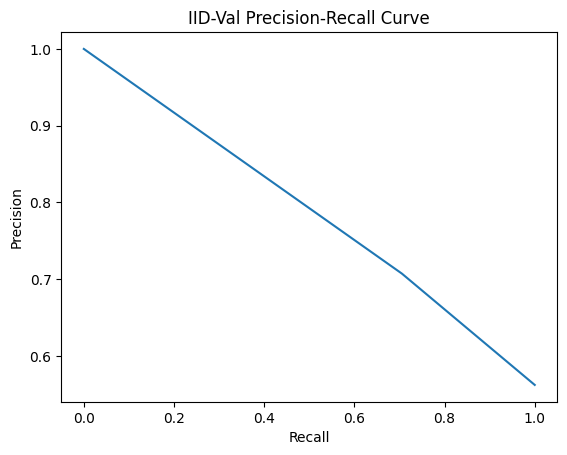

In [9]:
# Eval on iid val data
X_iid_val, Y_iid_val = data['iid_val']
X_iid_val_rand = model(X_iid_val)
evaluate(X_iid_val_rand, Y_iid_val, betas)

In [10]:
# Beta Model
mlp_ret = mlp_main(np.array(dirs), np.array(betas), X, model(X), percentile)
print(f"MLP Metrics:\n\tTest Loss - {mlp_ret['test_loss']}\n\Agreement: Overall - {mlp_ret['overall_agreement']}, Subset - {mlp_ret['subset_agreement']}")

Epoch 1/10


c:\ProgramData\anaconda3\envs\EveryDirHoldsSoln\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0695
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0682
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0659
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0642
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0620
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0602
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0579
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0553
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0539
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
MLP Metrics:
	Test Loss - 0.06045912206172943
\Agreement: Overall - 0.5409788227447057, Subset - 0.5743333333333334


In [11]:
# Draw new betas
gen_dirs, gen_betas = generate(mlp_ret['mlp'], M, K)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Accuracy:  0.5624332977588047


Precision:  0.5099099099099099
Recall:  0.672209026128266


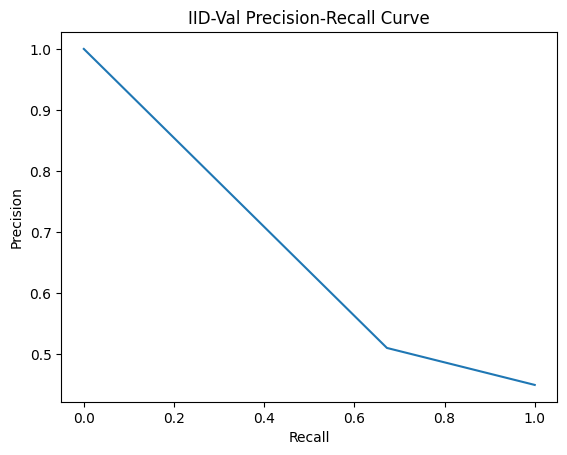

In [12]:
# Eval on ood val data
X_ood_val, Y_ood_val = data['ood_val']
X_ood_val_rand = model(X_ood_val)
evaluate(X_ood_val_rand, Y_ood_val, gen_betas)

Accuracy:  0.5714285714285714
Precision:  0.5719360568383659
Recall:  0.6666666666666666


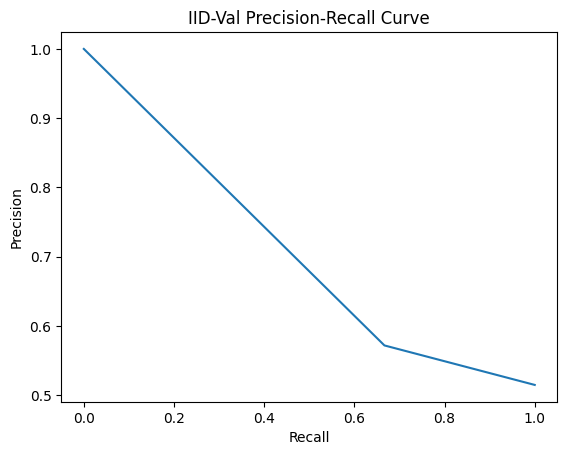

In [13]:
# Eval on ood test data
X_ood_test, Y_ood_test = data['ood_test']
X_ood_test_rand = model(X_ood_test)
evaluate(X_ood_test_rand, Y_ood_test, gen_betas)